Found 8704 files belonging to 4 classes.
Found 1536 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.
Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.80990, saving model to efficientnetb0_finetuned.keras
1088/1088 - 377s - 347ms/step - accuracy: 0.6980 - loss: 0.7007 - val_accuracy: 0.8099 - val_loss: 0.4152 - learning_rate: 1.0000e-04
Epoch 2/15

Epoch 2: val_accuracy improved from 0.80990 to 0.83724, saving model to efficientnetb0_finetuned.keras
1088/1088 - 336s - 309ms/step - accuracy: 0.7901 - loss: 0.4831 - val_accuracy: 0.8372 - val_loss: 0.3549 - learning_rate: 1.0000e-04
Epoch 3/15

Epoch 3: val_accuracy improved from 0.83724 to 0.87695, saving model to efficientnetb0_finetuned.keras
1088/1088 - 340s - 312ms/step - accuracy: 0.8295 - loss: 0.4027 - val_accuracy: 0.8770 - val_loss: 0.2844 - learning_rate: 1.0000e-04
Epoch 4/15

Epoch 4: val_accuracy improved from 0.87695 to 0.90169, saving model to efficientnetb0_finetuned.keras
1088/1088 - 346s -

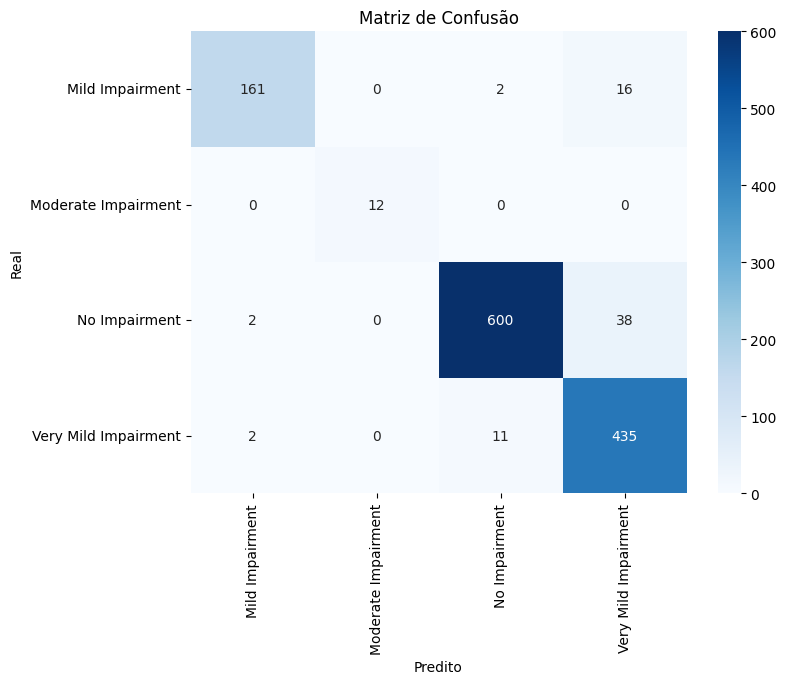


🔥 AUC Score (macro): 0.9945


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

img_size = (224, 224)
batch_size = 8
epochs = 15

train_dir = './data/train'
val_dir = './data/val'
test_dir = './data/test'

train_ds_raw = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size)
val_ds_raw = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size)
test_ds_raw = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=img_size, batch_size=batch_size)

class_names = train_ds_raw.class_names
num_classes = len(class_names)

train_ds = train_ds_raw.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds_raw.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)


y_train = list(itertools.chain(*[y.numpy().tolist() for _, y in train_ds_raw]))
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base_model.layers[:-30]:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x) 
output = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
    ModelCheckpoint("efficientnetb0_finetuned.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
]

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)

model.save("efficientnetb0_finetuned.keras")

best_model = tf.keras.models.load_model("efficientnetb0_finetuned.keras")

test_loss, test_acc = best_model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

y_true, y_pred, y_probs = [], [], []

for images, labels in test_ds:
    preds = best_model.predict(images)
    y_probs.extend(preds)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print("\n📋 Classification Reporefficientnetb0_finetunedt:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
auc = roc_auc_score(y_true_bin, np.array(y_probs), multi_class='ovr')
print(f"\n🔥 AUC Score (macro): {auc:.4f}")


In [5]:
img_size = (224, 224)
batch_size = 8

train_dir = './data/train'
val_dir = './data/val'

train_ds_raw = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size)
val_ds_raw = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size)

train_ds = train_ds_raw.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)

class_names = train_ds_raw.class_names
num_classes = len(class_names)
y_train = list(itertools.chain(*[y.numpy().tolist() for _, y in train_ds_raw]))
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

model = load_model("efficientnetb0_finetuned.keras")

model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
    ModelCheckpoint("efficientnetb0_finetuned_full.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
]

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)

model.save("efficientnetb0_finetuned_full.keras")


Found 8704 files belonging to 4 classes.
Found 1536 files belonging to 4 classes.
Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.97721, saving model to efficientnetb0_finetuned_full.keras
1088/1088 - 342s - 315ms/step - accuracy: 0.9745 - loss: 0.0761 - val_accuracy: 0.9772 - val_loss: 0.0550 - learning_rate: 1.0000e-05
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.97721
1088/1088 - 333s - 306ms/step - accuracy: 0.9783 - loss: 0.0652 - val_accuracy: 0.9759 - val_loss: 0.0536 - learning_rate: 1.0000e-05
Epoch 3/10

Epoch 3: val_accuracy improved from 0.97721 to 0.97917, saving model to efficientnetb0_finetuned_full.keras
1088/1088 - 342s - 314ms/step - accuracy: 0.9807 - loss: 0.0595 - val_accuracy: 0.9792 - val_loss: 0.0524 - learning_rate: 1.0000e-05
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.97917
1088/1088 - 347s - 319ms/step - accuracy: 0.9797 - loss: 0.0630 - val_accuracy: 0.9792 - val_loss: 0.0518 - learning_rate: 1.0000e-05
Epoch 5/10

Epoch 5


✅ Acurácia no Teste: 0.9656 | Perda: 0.1027

📋 Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.98      0.97      0.97       179
 Moderate Impairment       0.92      1.00      0.96        12
       No Impairment       0.97      0.97      0.97       640
Very Mild Impairment       0.95      0.96      0.95       448

            accuracy                           0.97      1279
           macro avg       0.96      0.97      0.97      1279
        weighted avg       0.97      0.97      0.97      1279



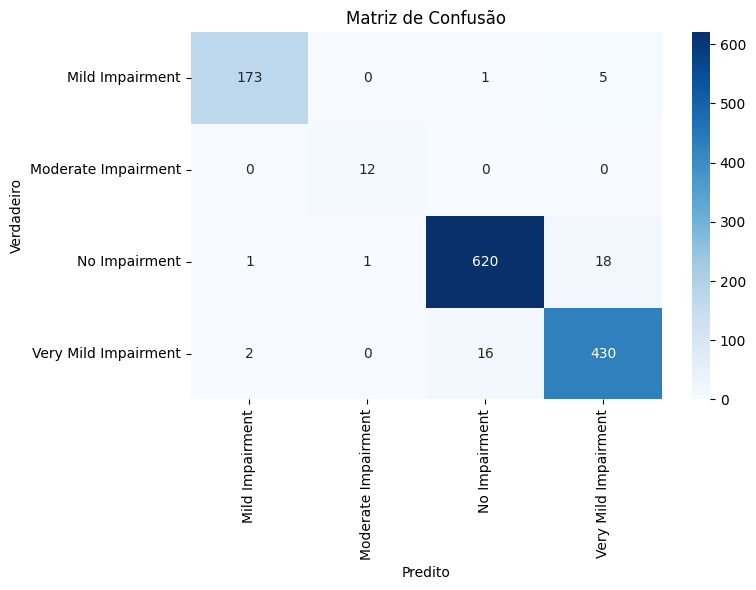


🔥 AUC Score (macro): 0.9967


In [6]:
model = load_model("efficientnetb0_finetuned_full.keras")

test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\n✅ Acurácia no Teste: {test_acc:.4f} | Perda: {test_loss:.4f}")

y_true, y_pred, y_probs = [], [], []
for x, y in test_ds:
    preds = model.predict(x, verbose=0)
    y_probs.extend(preds)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(y.numpy())

print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d',
            cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
auc_score = roc_auc_score(y_true_bin, np.array(y_probs), multi_class='ovr')
print(f"\n🔥 AUC Score (macro): {auc_score:.4f}")